In [1]:
import re
import os

Data Exploration

In [2]:
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/horse-or-human/train/'
val_data_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/horse-or-human/validation/'

In [3]:
import torch
import torchvision

PyTorch Custom Dataset

In [4]:
from torch.utils.data import Dataset

In [5]:
class trainDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.files = [fname for fname in os.listdir(root) if fname.endswith('.png')]
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    self.classes = []
    for file in self.files:
      name_spl = temp.match(file).groups()
      if name_spl[0] == 'human':
        self.classes.append(0)
      elif name_spl[0] == 'horse':
        self.classes.append(1)
    self.transform = transform
  
  def __len__(self):
    return len(self.files)
  
  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    class_idx = self.classes[i]
    return img, class_idx

In [6]:
class testDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.files = [fname for fname in os.listdir(root) if fname.endswith('.png')]
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    self.classes = []
    for file in self.files:
      name_spl = temp.match(file).groups()
      if name_spl[0] == 'valhuman':
        self.classes.append(0)
      elif name_spl[0] == 'horse':
        self.classes.append(1)
    self.transform = transform
  
  def __len__(self):
    return len(self.files)
  
  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    class_idx = self.classes[i]
    return img, class_idx

In [7]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_dataset = trainDataset(train_data_dir, T.Compose([T.Resize(img_size),
                                        T.Pad(8, padding_mode='reflect'),
                                        T.RandomCrop(img_size),
                                        T.ToTensor(),
                                        T.Normalize(*imagenet_stats)]))

val_dataset = testDataset(val_data_dir, T.Compose([T.Resize(img_size),
                                        T.Pad(8, padding_mode='reflect'),
                                        T.RandomCrop(img_size),
                                        T.ToTensor(),
                                        T.Normalize(*imagenet_stats)]))

In [8]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denormalize(images, means, stds):
  if len(images.shape) == 3:
    images = images.unsqueeze(0)
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images*stds + means

def show_image(img_tensor, label):
  print("Label: ", train_dataset.classes[label], '(' + str(label) + ')')
  img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1,2,0))
  plt.imshow(img_tensor)

Label:  1 (1)


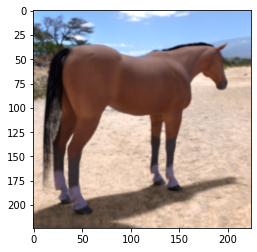

In [11]:
show_image(*train_dataset[2])

Creating Training and Validation Sets

In [12]:
from torch.utils.data import DataLoader

In [27]:
batch_size = 128
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(val_dataset, batch_size, pin_memory=True)

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16,16))
    ax.set_xticks([]); ax.set_yticks([])
    images = denormalize(images[:64], *imagenet_stats)
    ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
    break

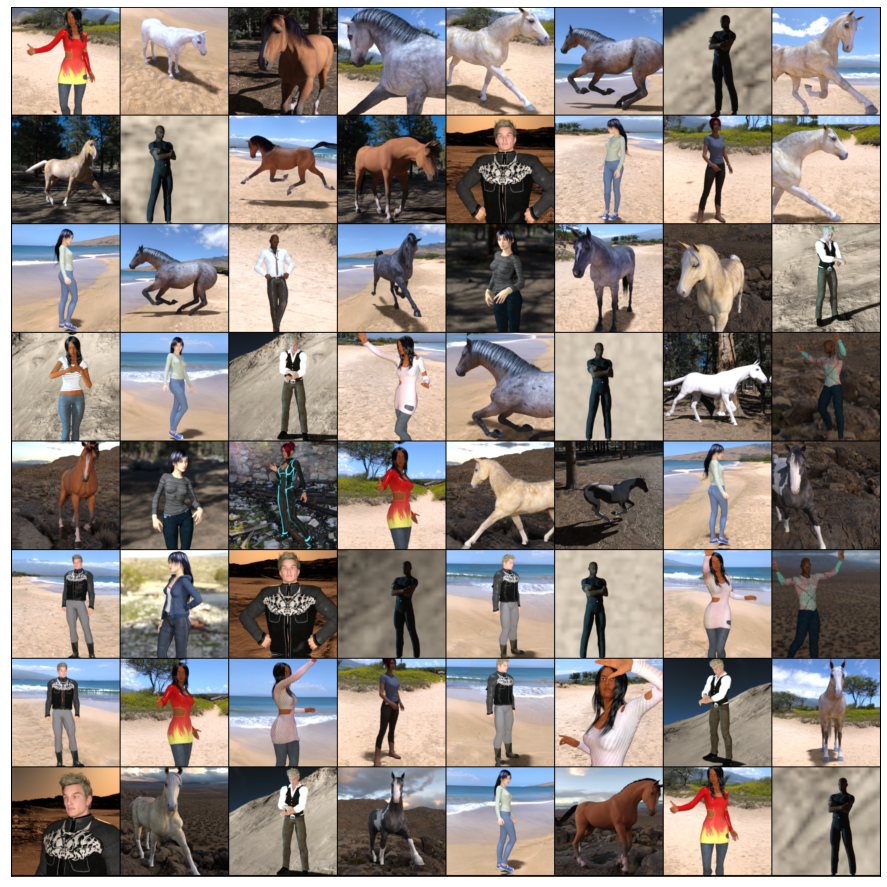

In [15]:
show_batch(train_dl)

In [59]:
import torch.nn as nn
import torch.nn.functional as F

In [70]:
def accuracy(out, labels):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(out == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    outs = self(images)
    loss = F.cross_entropy(outs, labels)
    return loss
  
  def validation_step(self, batch):
    images, labels = batch
    print(labels.shape)
    outs = self(images)
    print(outs.shape)
    loss = F.cross_entropy(outs, labels)
    acc = accuracy(outs, labels)
    return {"val_loss":loss.item(), "val_acc":acc}

  def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_accs = [x['val_loss'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], last lr: {result['lrs'][-1] if 'lrs' in result else ''}, training loss: {result['train_loss']:.4f}, validation loss: {result['val_loss']:.4f}, validation accuracy: {result['val_acc']:.4f}")

In [71]:
from torchvision import models

class HorseHumanClassificationModel(ImageClassificationBase):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    self.network = models.mobilenet_v2(pretrained=pretrained)
    self.network.classifier[1] = nn.Linear(self.network.classifier[1].in_features, 1)
    # self.network = self.model

  def forward(self, x):
    return self.network(x)

In [72]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [73]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [74]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [75]:
device = get_default_device()
device

device(type='cuda')

In [76]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [77]:
len(train_dataset.classes)

1027

In [78]:
model = HorseHumanClassificationModel(len(set(train_dataset.classes)))
to_device(model, device);

RuntimeError: ignored

In [69]:
history = [evaluate(model, valid_dl)]
history

RuntimeError: ignored